In [97]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import time

from pycsou.linop.conv import Convolve2D
from pycsou.func.loss import SquaredL2Loss
from pycsou.func.penalty import SquaredL2Norm, L2Norm, L1Norm, NonNegativeOrthant
from pycsou.opt.proxalgs import APGD, PDS
from pycsou.linop.diff import Gradient

from scripts.functionals import DCT2, HuberNorm, OptiConvolve2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Comparing Old and new Convolve2D Method in precision

[17 32]
(slice(4, 13, None), slice(7, 23, None), slice(0, 3, None))
(slice(4, 13, None), slice(8, 24, None), slice(0, 3, None))
Custom2D vs Convolve2D conv norm difference:  8.633167340280229e-14
Custom2D vs Convolve2D conv mean difference:  2.9934902293596812e-15
Custom2D vs Convolve2D corr norm difference:  9.615326208293849e-14
Custom2D vs Convolve2D corr mean difference:  3.528042056031053e-15


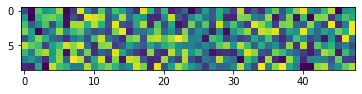

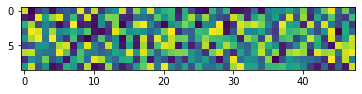

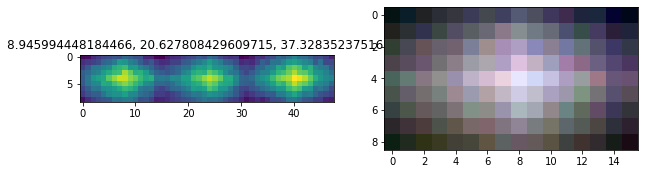

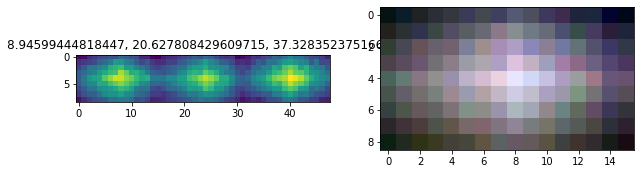

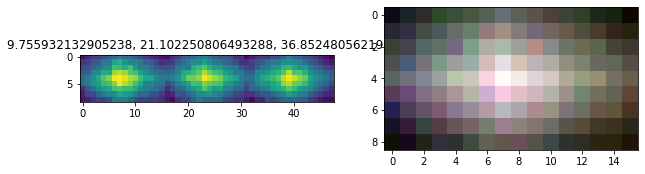

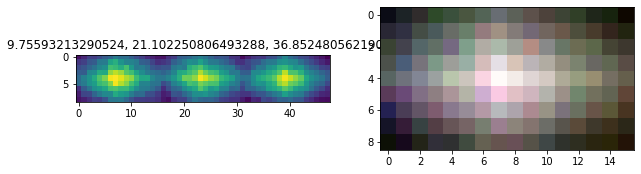

In [94]:
# ===========================================================================
# Custom Parameters: 
# - shape can be any size and channel number can be 1, 3, 4
# - dtype can be np.float32 or np.float64 if you want to see the impact on 
#   the precision with the original technique
    
shape = (9, 16, 3)
dtype = np.float64
offset_padding_factor = None

# =====================================================================

shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype)
x = np.random.rand(*shape).astype(dtype)
psf = np.random.rand(*shape).astype(dtype)

def conc_channels(v):
    return np.concatenate([v[:,:,i] for i in range(v.shape[2])], axis=1)

plt.figure()
plt.imshow(conc_channels(x))
plt.figure()
plt.imshow(conc_channels(psf))

H = OptiConvolve2D(psf)
print(H.fshape2d)
print(H.fslice2d_conv)
print(H.fslice2d_corr)
Hops = [Convolve2D(size=y.size/shape[2], filter=psf[:,:,i], shape=shape2d, method='fft') for i in range(shape[2])]

conv2d_conv = np.zeros_like(y)
for i in range(shape[2]):
    conv2d_conv[:,:,i] = Hops[i](x[:,:,i].flatten()).reshape(*shape2d)
custom2d_conv = H(x.flatten()).reshape(*shape)

conv2d_corr = np.zeros_like(y)
for i in range(shape[2]):
    conv2d_corr[:,:,i] = Hops[i].adjoint(y[:,:,i].flatten()).reshape(*shape2d)
custom2d_corr = H.adjoint(y.flatten()).reshape(*shape)

print("Custom2D vs Convolve2D conv norm difference: ", np.linalg.norm(conv2d_conv - custom2d_conv))
print("Custom2D vs Convolve2D conv mean difference: ", np.mean(np.abs(conv2d_conv - custom2d_conv)))
print("Custom2D vs Convolve2D corr norm difference: ", np.linalg.norm(conv2d_corr - custom2d_corr))
print("Custom2D vs Convolve2D corr mean difference: ", np.mean(np.abs(conv2d_corr - custom2d_corr)))
    
for t in [conv2d_conv, custom2d_conv, conv2d_corr, custom2d_corr]:
    fig, axs = plt.subplots(1,2, figsize=(10,10))
    axs[0].imshow(conc_channels(t))
    axs[0].set_title(f"{t.min()}, {t.mean()}, {t.max()}")
    t = (t - t.min())/(t.max() - t.min())
    axs[1].imshow(t)


### Comparing old and new Convolve2D method for Inverse Problem

d:\EPFL_Master\MA3\MFSP\DiffuserCam\diffcam_env\lib\site-packages\pycsou-1.0.6-py3.9.egg\pycsou\core\functional.py:152: UserWarning: For differentiable and/or linear maps, consider the dedicated classes DifferentiableMap and LinearOperator.


Custom2D time: 4.470134019851685
Custom2D time: 4.956152677536011
Custom2D time: 4.429529666900635
Custom2D time: 4.378836154937744
Custom2D time: 4.616203784942627
Custom2D time: 5.446787357330322
Custom2D time: 4.797799110412598
Custom2D time: 4.495986461639404
Custom2D time: 5.26032280921936
Custom2D time: 6.002942323684692
Convolve2D time: 2.451852560043335
Convolve2D time: 2.1850626468658447
Convolve2D time: 2.4310195446014404
Convolve2D time: 2.7050702571868896
Convolve2D time: 2.1729259490966797
Convolve2D time: 2.2043347358703613
Convolve2D time: 2.263566017150879
Convolve2D time: 2.1690027713775635
Convolve2D time: 2.164680242538452
Convolve2D time: 2.1807892322540283


Text(0.5, 1.0, 'Custom2D difference between measurement and Forward')

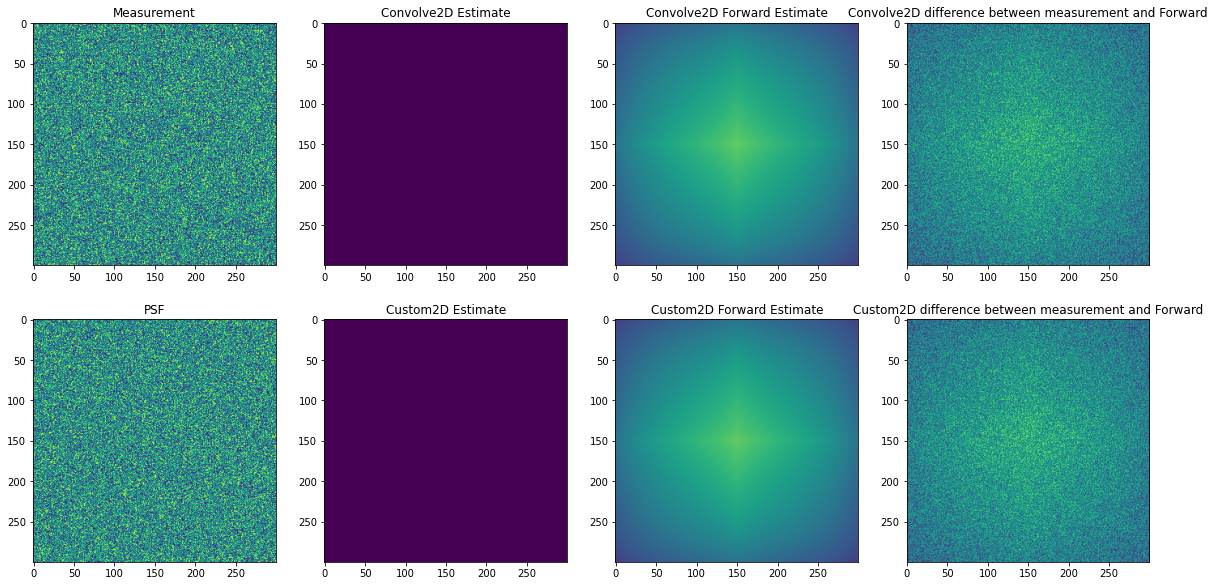

In [3]:
shape = (300, 300, 1)
dtype = np.float32


shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype)
psf = np.random.rand(*shape).astype(dtype)

def custom2d(y, psf, niter=10):
    Hop = OptiConvolve2D(psf)
    Hop.compute_lipschitz_cst(tol=5e-1)
    # Hop.compute_lipschitz_cst()
    lambda_ = 0.1
    l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y.flatten())
    F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

    apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                min_iter=1, max_iter=niter)

    estimate, _, _ = apgd.iterate()
    estimate = estimate['iterand'].reshape(y.shape)
    return estimate, Hop(estimate.flatten()).reshape(y.shape)
    
def conv2d(y, psf, niter=10):
    complete_estimate = np.zeros_like(y)
    complete_foresti = np.zeros_like(y)
    for i in range(y.shape[2]):
        yi_shape = y[:,:,i].shape
        Hop = Convolve2D(size=y[:,:,i].size, filter=psf[:,:,i], shape=yi_shape, method='fft')
        Hop.compute_lipschitz_cst(tol=5e-1)
        lambda_ = 0.1
        l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y[:,:,i].flatten())
        F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

        apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                    min_iter=1, max_iter=niter)

        estimate, _, _ = apgd.iterate()
        estimate = estimate['iterand'].reshape(yi_shape)
        complete_estimate[:,:,i] = estimate
        complete_foresti[:,:,i] = Hop(estimate.flatten()).reshape(yi_shape)
    return complete_estimate, complete_foresti

for _ in range(10):
    start_time = time.time()    
    custom2d_esti, custom2d_foresti = custom2d(y, psf)
    custom2d_elapsed = time.time() - start_time
    print("Custom2D time:", custom2d_elapsed)

for _ in range(10):
    start_time = time.time()
    conv2d_esti, conv2d_foresti = conv2d(y, psf)
    conv2d_elapsed = time.time() - start_time
    print("Convolve2D time:", conv2d_elapsed)

_, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0][0].imshow(y, vmin=0, vmax=1)
axs[0][0].set_title("Measurement")
axs[1][0].imshow(psf, vmin=0, vmax=1)
axs[1][0].set_title("PSF")
axs[0][1].imshow(conv2d_esti, vmin=0, vmax=1)
axs[0][1].set_title("Convolve2D Estimate")
axs[1][1].imshow(custom2d_esti, vmin=0, vmax=1)
axs[1][1].set_title("Custom2D Estimate")
axs[0][2].imshow(conv2d_foresti, vmin=0, vmax=1)
axs[0][2].set_title("Convolve2D Forward Estimate")
axs[1][2].imshow(custom2d_foresti, vmin=0, vmax=1)
axs[1][2].set_title("Custom2D Forward Estimate")
axs[0][3].imshow(conv2d_foresti - y, vmin=-1, vmax=1)
axs[0][3].set_title("Convolve2D difference between measurement and Forward")
axs[1][3].imshow(custom2d_foresti - y, vmin=-1, vmax=1)
axs[1][3].set_title("Custom2D difference between measurement and Forward")


In [100]:
shape = (1000, 1000, 1)
dtype = np.float64


shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype).flatten()
x = np.random.rand(*shape).astype(dtype).flatten()
psf = np.random.rand(*shape).astype(dtype)

custom_H = OptiConvolve2D(psf)
conv_H = Convolve2D(size=psf.size, filter=psf.squeeze(), shape=shape2d, method='fft')

print(conv_H.shape)
print(custom_H.shape)

iterations = 100

start_time = time.time()
for _ in range(iterations):
    conv_H(x)
conv_average_elapsed_time = (time.time() - start_time)/iterations
print("Convolve2D conv:", conv_average_elapsed_time)

start_time = time.time()
for _ in range(iterations):
    custom_H(x)
custom_average_elapsed_time = (time.time() - start_time)/iterations
print("Custom2D conv:", custom_average_elapsed_time)

start_time = time.time()
for _ in range(iterations):
    conv_H.adjoint(y)
conv_average_elapsed_time = (time.time() - start_time)/iterations
print("Convolve2D conv:", conv_average_elapsed_time)

start_time = time.time()
for _ in range(iterations):
    custom_H.adjoint(y)
custom_average_elapsed_time = (time.time() - start_time)/iterations
print("Custom2D conv:", custom_average_elapsed_time)



ValueError: h must be 2-dimensional